In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [2]:
# !kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

In [3]:
# import zipfile
# with zipfile.ZipFile("human-emotions-datasethes.zip", 'r') as zip_ref:
#     zip_ref.extractall()

In [4]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [5]:
train_dir="c:/Users/alisu/Desktop/ML/Human Emotion Detection/Emotions Dataset/Emotions Dataset/train"
val_dir="c:/Users/alisu/Desktop/ML/Human Emotion Detection/Emotions Dataset/Emotions Dataset/test"

In [6]:
# Class Names
import os

def get_folder_names(directory):
    folder_names = []
    
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            folder_names.append(item)
    
    return folder_names

# Replace 'path_to_your_directory' with the actual path of the directory you want to search
directory_path = train_dir
CLASS_NAMES = get_folder_names(directory_path)

print("Class names:", CLASS_NAMES)


Class names: ['angry', 'happy', 'sad']


In [7]:
train_data= tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 6799 files belonging to 3 classes.


In [8]:
val_data= tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 2278 files belonging to 3 classes.


In [38]:
# for i in val_data.take(1):
#     print(i)

In [10]:
# class_names = CLASS_NAMES

# # Take the first batch from the dataset
# for images, labels in train_data.take(1):
#     # Plot the images and their class names
#     plt.figure(figsize=(10, 10))
#     for i in range(16):
#         plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
    
#     plt.show()

In [11]:
training_data = (
train_data
.prefetch(tf.data.AUTOTUNE)
)

In [12]:
validation_data = (
val_data
.prefetch(tf.data.AUTOTUNE)
)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
       Rescaling(1./255),                               
])

In [14]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [15]:
loss_function = CategoricalCrossentropy()

In [16]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [17]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [25]:
history = lenet_model.fit(
  training_data,
  validation_data = validation_data,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20


213/213 [==============================] - 16s 72ms/step - loss: 0.0573 - accuracy: 0.9753 - top_k_accuracy: 0.9987 - val_loss: 1.1989 - val_accuracy: 0.7151 - val_top_k_accuracy: 0.8924
Epoch 2/20
213/213 [==============================] - 15s 72ms/step - loss: 0.0564 - accuracy: 0.9748 - top_k_accuracy: 0.9979 - val_loss: 1.1750 - val_accuracy: 0.7375 - val_top_k_accuracy: 0.8986
Epoch 3/20
213/213 [==============================] - 15s 72ms/step - loss: 0.0735 - accuracy: 0.9696 - top_k_accuracy: 0.9981 - val_loss: 1.2364 - val_accuracy: 0.7261 - val_top_k_accuracy: 0.8999
Epoch 4/20
213/213 [==============================] - 15s 72ms/step - loss: 0.0661 - accuracy: 0.9721 - top_k_accuracy: 0.9979 - val_loss: 1.1680 - val_accuracy: 0.7476 - val_top_k_accuracy: 0.9047
Epoch 5/20
213/213 [==============================] - 16s 73ms/step - loss: 0.0529 - accuracy: 0.9746 - top_k_accuracy: 0.9984 - val_loss: 1.2026 - val_accuracy: 0.7384 - val_top_k_accuracy: 0.9056
Epoch 6/20
213/213 [=

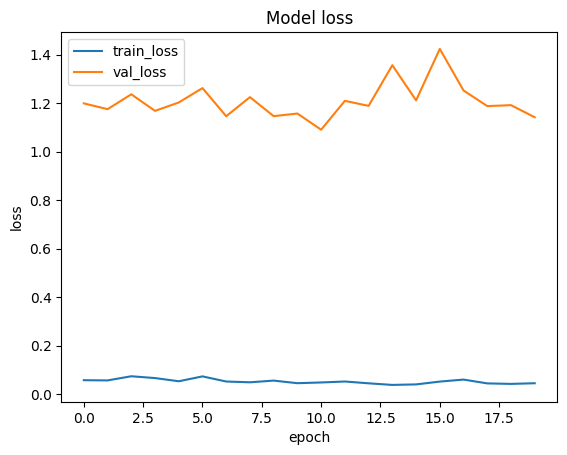

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

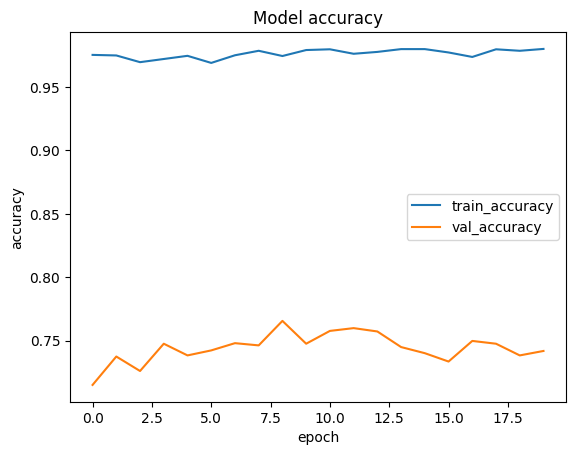

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [29]:
lenet_model.evaluate(validation_data)

72/72 [==============================] - 2s 24ms/step - loss: 1.1416 - accuracy: 0.7419 - top_k_accuracy: 0.9122


[1.1416243314743042, 0.741878867149353, 0.9122036695480347]

In [41]:
test_image = cv2.imread("c:/Users/alisu/Desktop/ML/Human Emotion Detection/Emotions Dataset/Emotions Dataset/test/sad/35028.jpg")
im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)
print(lenet_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

tf.Tensor([[3.586389e-07 7.948175e-05 9.999201e-01]], shape=(1, 3), dtype=float32)
sad


In [39]:
# plt.figure(figsize = (12,12))

# for images, labels in validation_data.take(1):
#   for i in range(16):
#     ax = plt.subplot(4,4, i+1)
#     plt.imshow(images[i]/255.)

#     plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()] 
#               + "\n" + "Predicted Label - : " 
#               + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
#     plt.axis("off")


In [43]:
predicted = []
labels = []

for im, label in validation_data:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

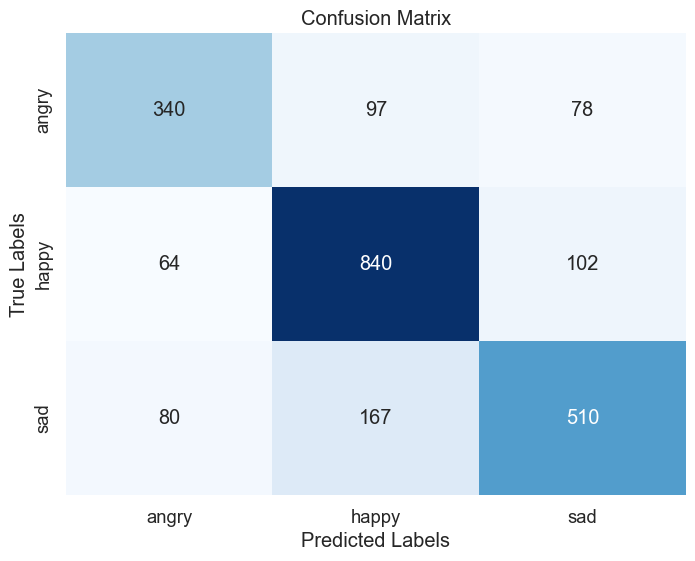

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have true labels and predicted labels
true_labels = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
predicted_labels = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for readability

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
